# Heart Disease Risk Estimator AI

This notebook demonstrates how to build an AI model to estimate heart disease risk using the UCI Heart Disease dataset. We will use pandas, numpy, and TensorFlow (Keras) for this task. The workflow includes data loading, preprocessing, model building, training, evaluation, and saving the model for deployment.

**Note: For best performance, use a machine with a GPU.**

## 1. Import Required Libraries

In [10]:
# import all the necessary libraries needed for our AI model.

import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

## 2. Load the Dataset
We will load the UCI Heart Disease dataset and explore its structure.

In [11]:
# use pandas to read the CSV file containing the heart disease dataset.

file_path = 'heart_disease_uci.csv'
df = pd.read_csv(file_path)
print('Shape:', df.shape)
df.head()

Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [12]:
# check for missing values and data types
print(df.info())
print(df.isnull().sum())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs         

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


## 3. Data Preprocessing
We will encode categorical variables, handle missing values, and prepare the data for model training.

In [13]:
# drop columns that are not needed like id and dataset
df = df.drop(['id', 'dataset'], axis=1)

def fill_missing(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    return df

df = fill_missing(df)

# encode categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# features and target
y = df['num']
X = df.drop('num', axis=1)
y = (y > 0).astype(int)

C:\Users\jarom\AppData\Local\Temp\ipykernel_9208\15782726.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
C:\Users\jarom\AppData\Local\Temp\ipykernel_9208\15782726.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [14]:
print('Class distribution:')
print(y.value_counts())

Class distribution:
num
1    509
0    411
Name: count, dtype: int64


## 4. Split Data into Training and Test Sets

In [15]:
# prepare the data for building, training, and testing the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5. Build the Model
We will define a simple neural network using TensorFlow/Keras.

In [16]:
# building the model using keras of tensorflow
model = keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\jarom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


C:\Users\jarom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

C:\Users\jarom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,769 (190.50 KB)

 Trainable params: 47,809 (186.75 KB)

 Non-trainable params: 960 (3.75 KB)

## 6. Train the Model
We will now train the model using the training set and validate on the validation set. 

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8496 - loss: 0.3356 - val_accuracy: 0.8108 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8557 - loss: 0.3504

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8496 - loss: 0.3356 - val_accuracy: 0.8108 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8557 - loss: 0.3504

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8496 - loss: 0.3356 - val_accuracy: 0.8108 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8557 - loss: 0.3504

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8563 - loss: 0.3497 - val_accuracy: 0.7905 - val_loss: 0.4975 - learning_rate: 5.0000e-04
Epoch 7/50
Epoch 7/50
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8611 - loss: 0.3054

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8496 - loss: 0.3356 - val_accuracy: 0.8108 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8557 - loss: 0.3504

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8563 - loss: 0.3497 - val_accuracy: 0.7905 - val_loss: 0.4975 - learning_rate: 5.0000e-04
Epoch 7/50
Epoch 7/50
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8611 - loss: 0.3054

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8496 - loss: 0.3356 - val_accuracy: 0.8108 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8557 - loss: 0.3504

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8563 - loss: 0.3497 - val_accuracy: 0.7905 - val_loss: 0.4975 - learning_rate: 5.0000e-04
Epoch 7/50
Epoch 7/50
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8611 - loss: 0.3054

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8621 - loss: 0.3043 - val_accuracy: 0.8108 - val_loss: 0.4686 - learning_rate: 5.0000e-04
Epoch 8/50
Epoch 8/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9097 - loss: 0.2780

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8496 - loss: 0.3356 - val_accuracy: 0.8108 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8557 - loss: 0.3504

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8563 - loss: 0.3497 - val_accuracy: 0.7905 - val_loss: 0.4975 - learning_rate: 5.0000e-04
Epoch 7/50
Epoch 7/50
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8611 - loss: 0.3054

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8621 - loss: 0.3043 - val_accuracy: 0.8108 - val_loss: 0.4686 - learning_rate: 5.0000e-04
Epoch 8/50
Epoch 8/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9097 - loss: 0.2780

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8496 - loss: 0.3356 - val_accuracy: 0.8108 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8557 - loss: 0.3504

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8563 - loss: 0.3497 - val_accuracy: 0.7905 - val_loss: 0.4975 - learning_rate: 5.0000e-04
Epoch 7/50
Epoch 7/50
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8611 - loss: 0.3054

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8621 - loss: 0.3043 - val_accuracy: 0.8108 - val_loss: 0.4686 - learning_rate: 5.0000e-04
Epoch 8/50
Epoch 8/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9097 - loss: 0.2780

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9096 - loss: 0.2780 - val_accuracy: 0.8176 - val_loss: 0.4506 - learning_rate: 5.0000e-04
Epoch 9/50
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8970 - loss: 0.2580 - val_accuracy: 0.8176 - val_loss: 0.4540 - learning_rate: 5.0000e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8970 - loss: 0.2580 - val_accuracy: 0.8176 - val_loss: 0.4540 - learning_rate: 5.0000e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9090 - loss: 0.2520 - val_accuracy: 0.8041 - val_loss: 0.4691 - learning_rate: 5.0000e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9090 - loss: 0.2520 - val_accuracy: 0.8041 - val_loss: 0.4691 - learning_rate: 5.0000e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9199 - loss: 0.2253 - val_accuracy: 0.7905 - val_loss: 0.4967 - learning_rate: 5.0000e-04
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.

Epoch 1/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6185 - loss: 0.6800

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6243 - loss: 0.6719 - val_accuracy: 0.7703 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.3923

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8357 - loss: 0.3933 - val_accuracy: 0.7838 - val_loss: 0.5979 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8624 - loss: 0.3376

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8594 - loss: 0.3418 - val_accuracy: 0.7905 - val_loss: 0.5719 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8543 - loss: 0.3607

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8542 - loss: 0.3601 - val_accuracy: 0.7973 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8493 - loss: 0.3358

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8496 - loss: 0.3356 - val_accuracy: 0.8108 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8557 - loss: 0.3504

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8563 - loss: 0.3497 - val_accuracy: 0.7905 - val_loss: 0.4975 - learning_rate: 5.0000e-04
Epoch 7/50
Epoch 7/50
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8611 - loss: 0.3054

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8621 - loss: 0.3043 - val_accuracy: 0.8108 - val_loss: 0.4686 - learning_rate: 5.0000e-04
Epoch 8/50
Epoch 8/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9097 - loss: 0.2780

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9096 - loss: 0.2780 - val_accuracy: 0.8176 - val_loss: 0.4506 - learning_rate: 5.0000e-04
Epoch 9/50
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8970 - loss: 0.2580 - val_accuracy: 0.8176 - val_loss: 0.4540 - learning_rate: 5.0000e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8970 - loss: 0.2580 - val_accuracy: 0.8176 - val_loss: 0.4540 - learning_rate: 5.0000e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9090 - loss: 0.2520 - val_accuracy: 0.8041 - val_loss: 0.4691 - learning_rate: 5.0000e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9090 - loss: 0.2520 - val_accuracy: 0.8041 - val_loss: 0.4691 - learning_rate: 5.0000e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9199 - loss: 0.2253 - val_accuracy: 0.7905 - val_loss: 0.4967 - learning_rate: 5.0000e-04
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.

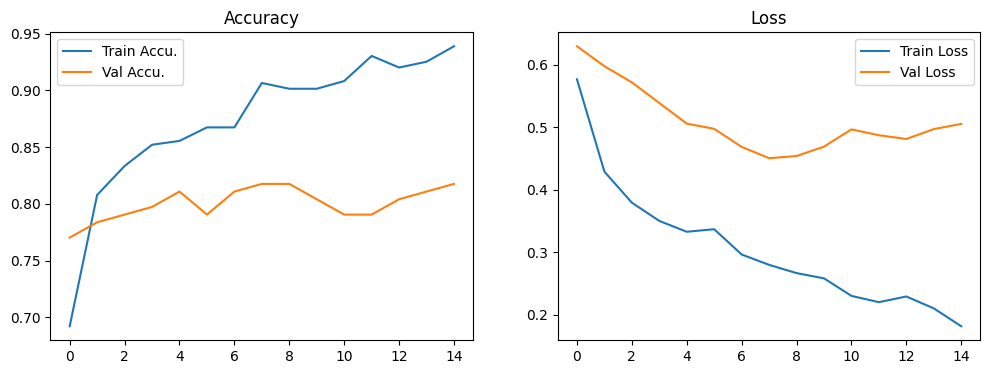

In [17]:
# training the model for more accurate results

checkpoint_cb = ModelCheckpoint('best_heart_disease_model.h5', save_best_only=True, monitor='val_loss')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_reduce],
    verbose=1
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accu.')
plt.plot(history.history['val_accuracy'], label='Val Accu.')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

## 7. Evaluate the Model
We will now evaluate the trained model on the test set and visualize the results.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Test Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        82
           1       0.82      0.82      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

Test Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        82
           1       0.82      0.82      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Test Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        82
           1       0.82      0.82      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

Test Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        82
           1       0.82      0.82      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



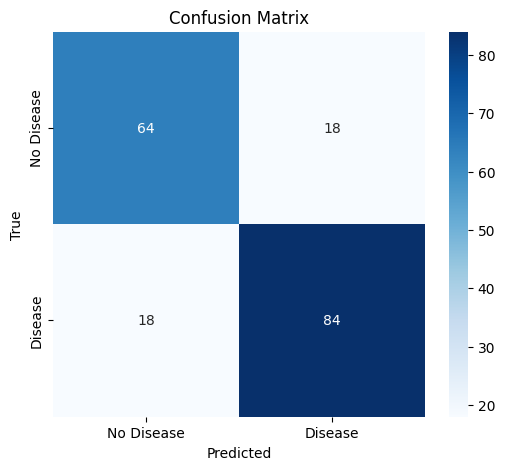

In [18]:
# this is used to evauate the test accuracy of the model

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print('Test Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 8. Save the Model
We will save the trained model for later use in an application.

In [19]:
# saving the model to prepare for deployment on api

# Ensure the model directory exists before saving
os.makedirs('model', exist_ok=True)
# Save the main model
model.save('model/heart_disease_model.keras')
# Move the best model to the model folder
if os.path.exists('best_heart_disease_model.h5'):
    shutil.move('best_heart_disease_model.h5', 'model/best_heart_disease_model.h5')
    print('Both models saved in model folder.')
else:
    print('Main model saved. best_heart_disease_model.h5 not found.')

Both models saved in model folder.
